At it's core, this is just regression.  We use a regression model over pre and post treatment periods to estimate the causal effect of an intervention which we did not run an experiment on.  This is by no means perfect. In fact, this is a very simplistic approach which should be taken with a grain of salt.  It makes no assumptions about having a control group, or even a synthetic control to compare to.  This can happen in instances where a feature is shipped globally to everyone at the same time.  We don't handle staggered adoption here either.  No additional controls outside of quantities derived from the observed time series are used, so use with at your own risk.  

Naive interupted Time Series

This is a super simple approach. All we're doing is fitting the regression model

$$Y = \beta_{0} + \beta_{1} T + \beta_{2} D + \beta_{3} P + ϵ$$,

Where:

$ Y $ is the outcome variable (In this case it's number of retail adds)

$ T $ is a continuous variable which indicates the time passed from start of the observational period

$ D $ is a dummy variable indicating observations collected before ($ D = 0 $) or after ($ D = 1 $) the intervention

$ P $ is a continuous variable indicating the time passed since the intervention has occurred (before the intervention has occurred P is equal to 0)

$ \epsilon $ represents the zero centered Gaussian random error term

We'll explore an alternative here as well which replaces the simple Ordinary Least Squares (OLS) model above with an ARIMA (AutoRegressive Integrated Moving Average) model to capture auto-correlations in our time series.  These auto-correlations can cause some of the assumptions behind OLS to breakdown, making our model somewhat questionable.  The workflow here is essentially a simplified form of the standard causal inference proceedure: 

1. Identify (i.e. determine if there are causal paths in your data generate process)

2. Estimate (i.e. use some model/calculation to estimate the effect of the above)

3. Refute (i.e. challenge the estimate and tell me why my model is wrong)

In [21]:
import sys
import pandas as pd

In [6]:
# For now, this is a simple way to import the tools we need.
# Be sure to update the path to point to where the relevant code is stored on your machine
# TBD on eventually making this importable
sys.path.append('../../../quasi_experiment_utils/')

In [7]:
import interrupted_time_series_utils

In [93]:
# Load data
# df = pd.read_csv('../../../../data/mock_data_for_interrupted_ts_2.csv')
df = pd.read_csv('../../../../data/mock_time_series_4.csv')

In [94]:
df.head()

,date,outcome
0,2022-06-01,5172.044045
1,2022-06-02,5189.807480
2,2022-06-03,5199.184926
3,2022-06-04,5225.774801
4,2022-06-05,5178.962136


The mock data here represents a time series of some outcome variable.  This could be a business critical metric, or the result of an purposeful intervention without a well defined control group. (FIX THIS DESCRIPTION)

ADD MORE DESCRIPTION OF THE DATA

In [95]:
df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)

In [96]:
df.head()

,date,outcome
0,2022-06-01,5172.044045
1,2022-06-02,5189.807480
2,2022-06-03,5199.184926
3,2022-06-04,5225.774801
4,2022-06-05,5178.962136


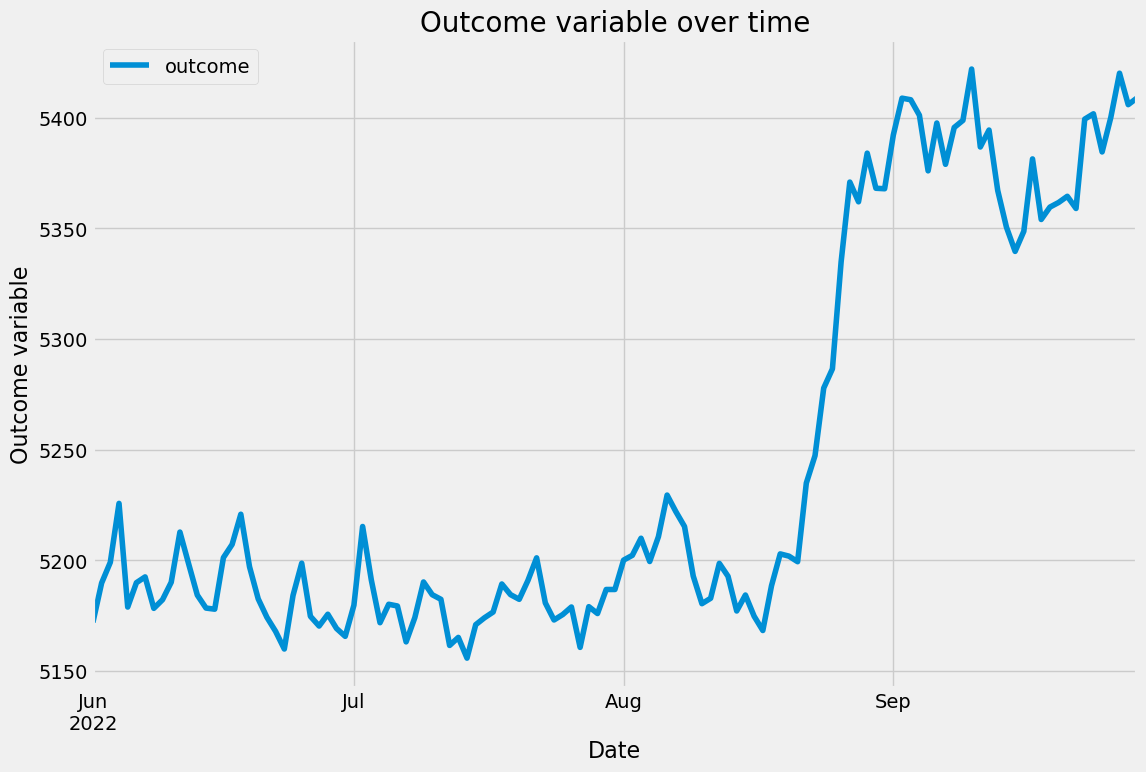

In [97]:
# Let's take a look at the data before doing anything
ax = df.set_index('date').plot(figsize=(12, 8))
ax.set_title('Outcome variable over time', fontsize=20)
ax.set_ylabel('Outcome variable', fontsize=16)
ax.set_xlabel('Date', fontsize=16)
xtl=[item.get_text()[:10] for item in ax.get_xticklabels()]
_=ax.set_xticklabels(xtl)

In [106]:
# Let's try and estimate the effect here (which we can clearly see). We'll start with a simple Interrupted Time Series model
# First we need to specify the date on which the intervention occured. For us, it's August 24th, 2022
# treatment_date = datetime.datetime(2023, 3, 1)
treatment_date = datetime.datetime(2022, 8, 20)
interrupted_ts = interrupted_time_series_utils.InterruptedTimeSeries(treatment_date=treatment_date)

As described above, this is really a simple OLS model.  Accordingly, we can read off the estimated impact of the intervention from the coefficients of the model (it's the $D$ coefficient).  The code here will translate this for you into a relative lift below the model summary. Here, it's estimated to be 3.1% 95% CI: (2.77% - 3.42%) and the p-value < 0.05 (this is customizable as well, but 0.05 is the default value).  

Of course, this estimate is model dependent, so we should ask if our model is any good.  The interrupted_time_series() method will apply a few checks, depending on the model_type specified.  Here it tests:

1. Jarque-Bera statistic.  This is a measure of how well the residuals of the model follow a normal distribution. This is one of the assumptions of OLS.  In our case here, this appears to be violated.

    a. It can also be helpful to visually inspect the distribution of the residuals. Small data samples are less likely to look normal, even though the model might be more or less reasonable. 
    
2. Durbin-Waston statistic.  This is a measure of whether or not the residuals are independent (another assumption of OLS).  In this case, the test indicates that there is evidence of positive auto-correlation in our residuals 

If any of the tests fail, recommendations about what to try next are made.  In our case, it is recommeneded to investigate the failure of the residuals to be normally distributed, as well as suggested that we try a different model type to handle the non-independence of the residuals in our original model.  To help with the latter point, the autocorrelation and partial autocorrelation plots of the model residuals are presented (these are not the same as the equivalent plots for the actual data).  

The last output is a plot summarizing the estimated impact, its significance, and a plot of how the counterfactual estimates (along with their confidence interval) from the model compare to the actual data, as well as the model predictions in the pre and post periods (these are the blue line. They are not counterfactuals).  

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.900
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     349.2
Date:                Tue, 27 Aug 2024   Prob (F-statistic):           3.41e-58
Time:                        16:44:22   Log-Likelihood:                -576.73
No. Observations:                 121   AIC:                             1161.
Df Residuals:                     117   BIC:                             1173.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5184.7491      6.526    794.521      0.0

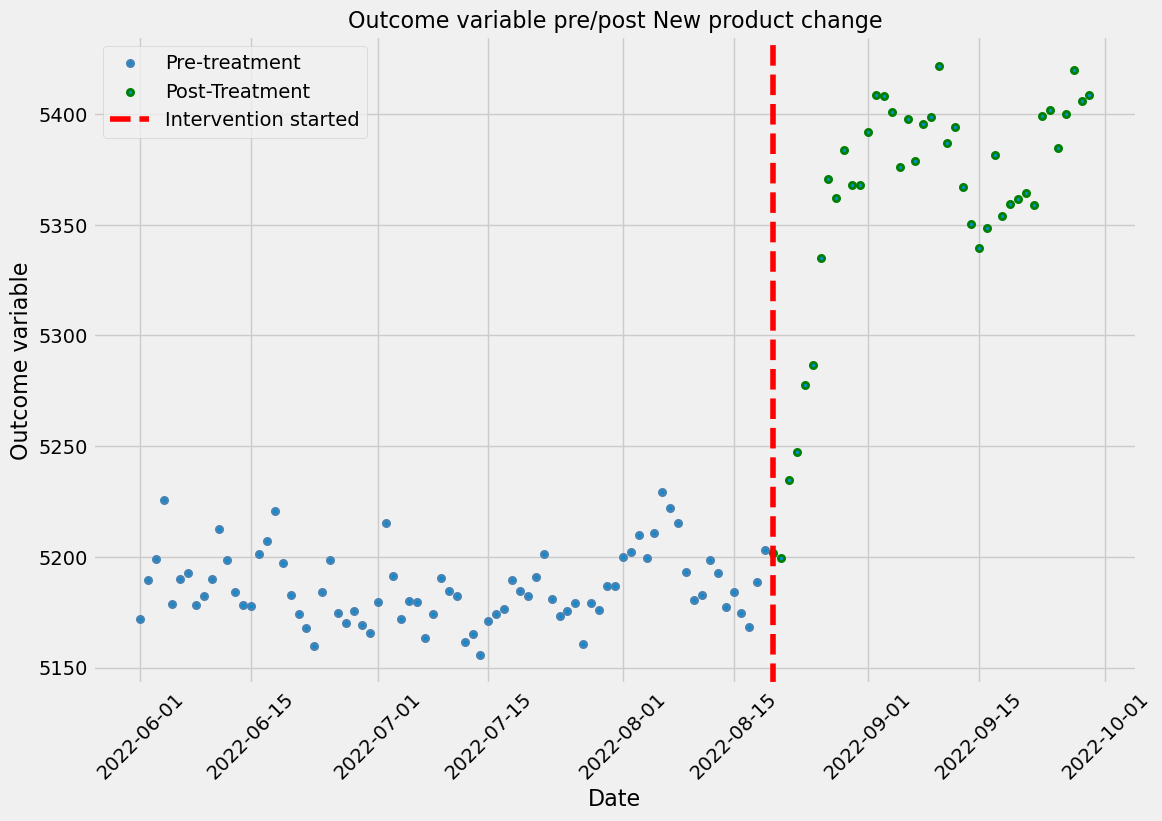

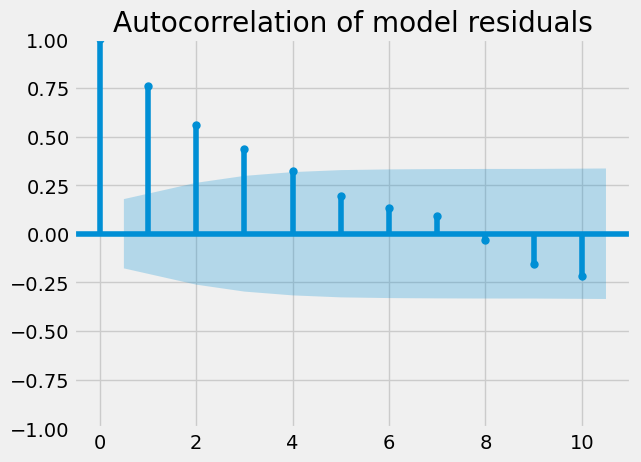

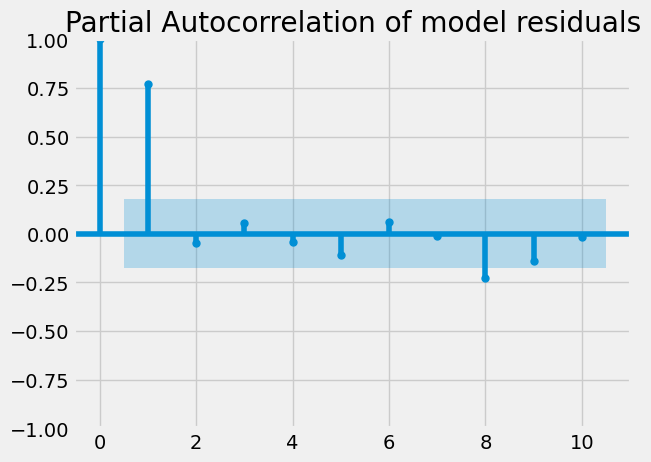

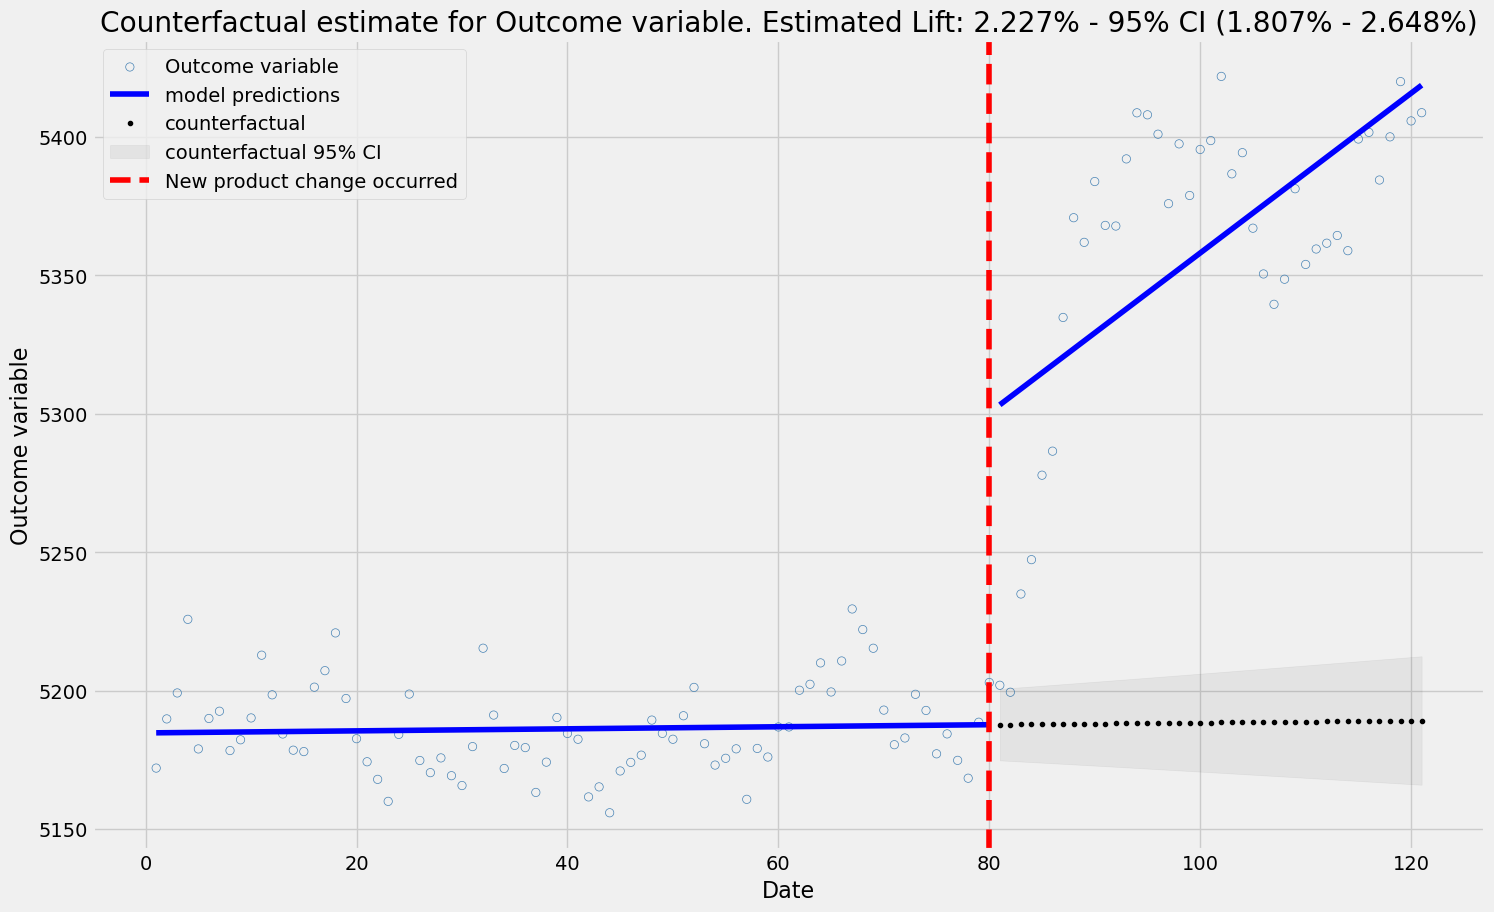

In [107]:
interrupted_ts.interrupted_time_series(df=df, 
                                       model_type='interrupted_time_series', 
                                       date_col='date', 
                                       outcome_name='Outcome variable', 
                                       outcome_col='outcome', 
                                       treatment_name='New product change')

One of the suggestions above was to try using an ARIMA model as our estimator, rather than a simple OLS.  The concept for an ARIMA model is essentially the same, except that we can better account of leading/lagging effects in our observations, as well as potential seasonality.  A nice paper describing how this works can be found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7986567/).  Note that the paper describes a few additional extensions to this methodology which are not yet implemented in the stats_utils package.  We plan on adding some, if not all, of these in the future.  

In [108]:
naive_arima_interrupted_ts = interrupted_time_series_utils.InterruptedTimeSeries(treatment_date=treatment_date)

We can fit a naive arima model by passing in some order parameters. Estimating the right parameters can be tricky (you can read about how to do it [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7986567/)). We'll just pick at random to demonstrate the functionality. Also, it's important that your time series data be made stationary before fitting an ARIMA model.  You don't need to do this yourself though, it wil lbe done for your automatically

This new model is quite a bit worse. This is not surprising, considering we just randomly selected the order parameters for the underlying ARIMA model.  In this case, the model finds no evidence for a statistically significant effect.  

Several assumptions about the model are tested here as well.  In this case, the Jarque-Bera test fails, indicating that the model residuals are not normally distributed. Furthermore, the Ljung-Box test fails, which indicates serial autocorrelation in the model residuals (this is a problem for an ARIMA model).  Like in the naive OLS approach, recommendations are made about what to do next.  In particular, we should re-evaluate our choice of models.  

A plot summarizing the model, along with the estimated counterfactuals and effect estimate is shown at the bottom of the output.  The model looks terrible here, as expected. The 95% confidence interval around the counterfactuals completely envelops the actual observed data, so a significant effect is not expected. 

INFO: Fitting non-seasonal ARIMA
                               SARIMAX Results                                
Dep. Variable:                outcome   No. Observations:                  121
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -508.421
Date:                Tue, 27 Aug 2024   AIC                           1030.843
Time:                        16:44:39   BIC                           1050.413
Sample:                             0   HQIC                          1038.791
                                - 121                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5168.4590     49.187    105.077      0.000    5072.054    5264.864
T              0.7156      0.915      0.782      0.434      -1.077       2.508
D              6.25

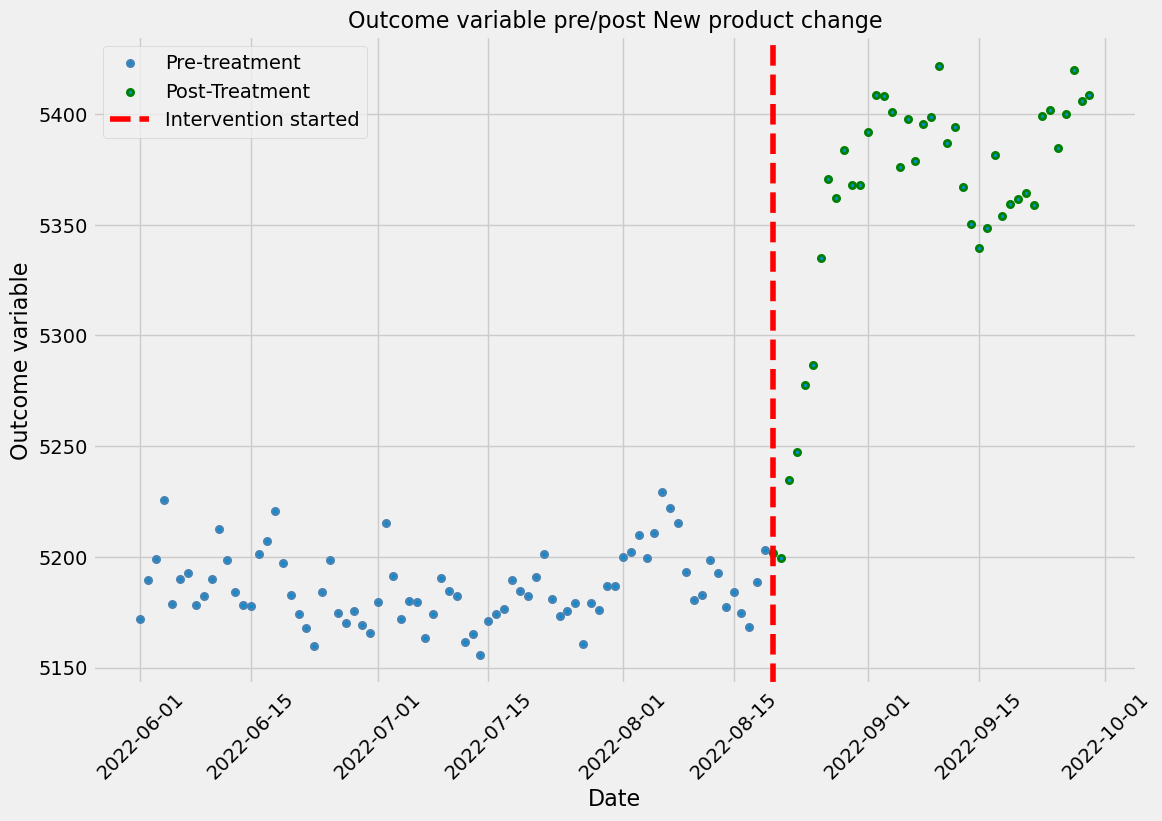

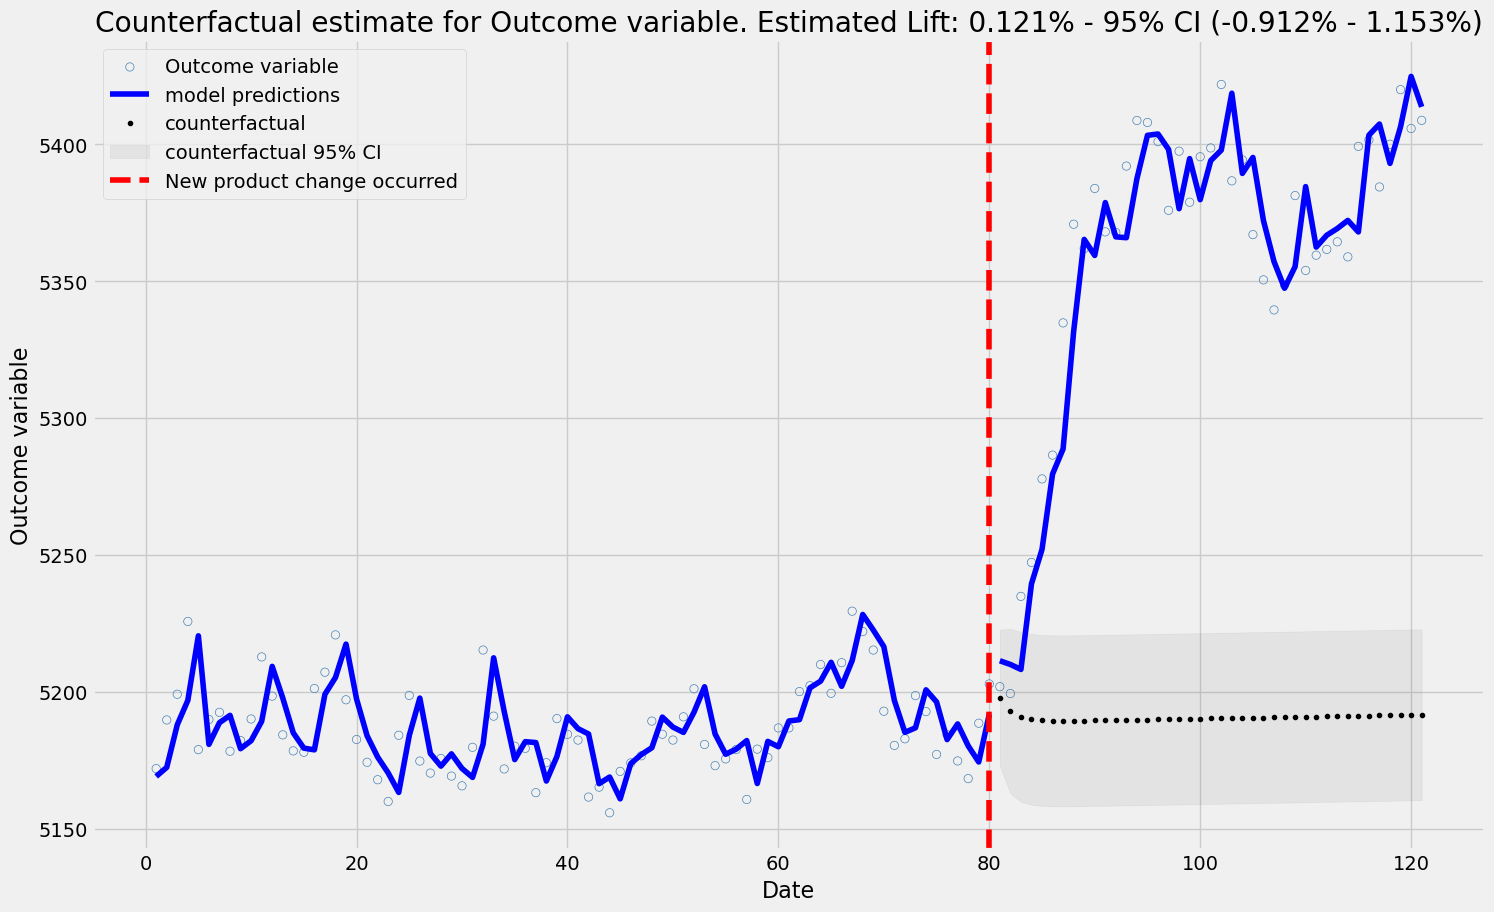

In [109]:
naive_arima_interrupted_ts.interrupted_time_series(df=df, 
                                                   model_type='naive_arima_interrupted_time_series', 
                                                   date_col='date', 
                                                   outcome_name='Outcome variable', 
                                                   outcome_col='outcome', 
                                                   treatment_name='New product change',
                                                   arima_params_dict={'order': (1, 0, 1)})

Estimating the right order parameters for your ARIMA model can be tricky to do by eye.  Fortunantely, this is not required as the package here supports fitting and auto ARMIA model.  Meaning that it will find the best order parameters for you. 

In [90]:
auto_arima_interrupted_ts = interrupted_time_series_utils.InterruptedTimeSeries(treatment_date=treatment_date)

INFO: Fitting non-seasonal auto ARIMA
INFO: Setting default seasonal period to 1 (i.e. non-seasonal)
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.27 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1644.783, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.07 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.11 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=479.319, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=inf, Time=0.29 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=586.997, Time=0.18 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=inf, Time=0.14 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=465.379, Time=0.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=533.577, Time=0.19 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.24 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=

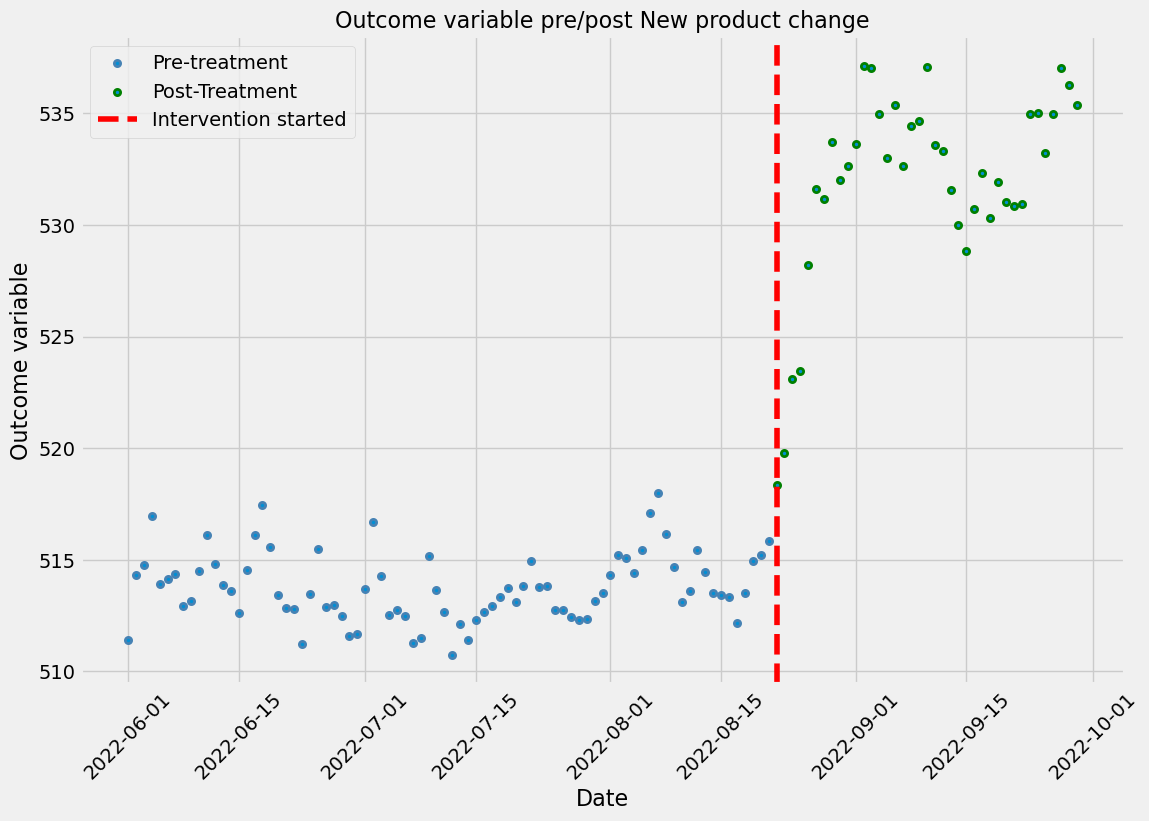

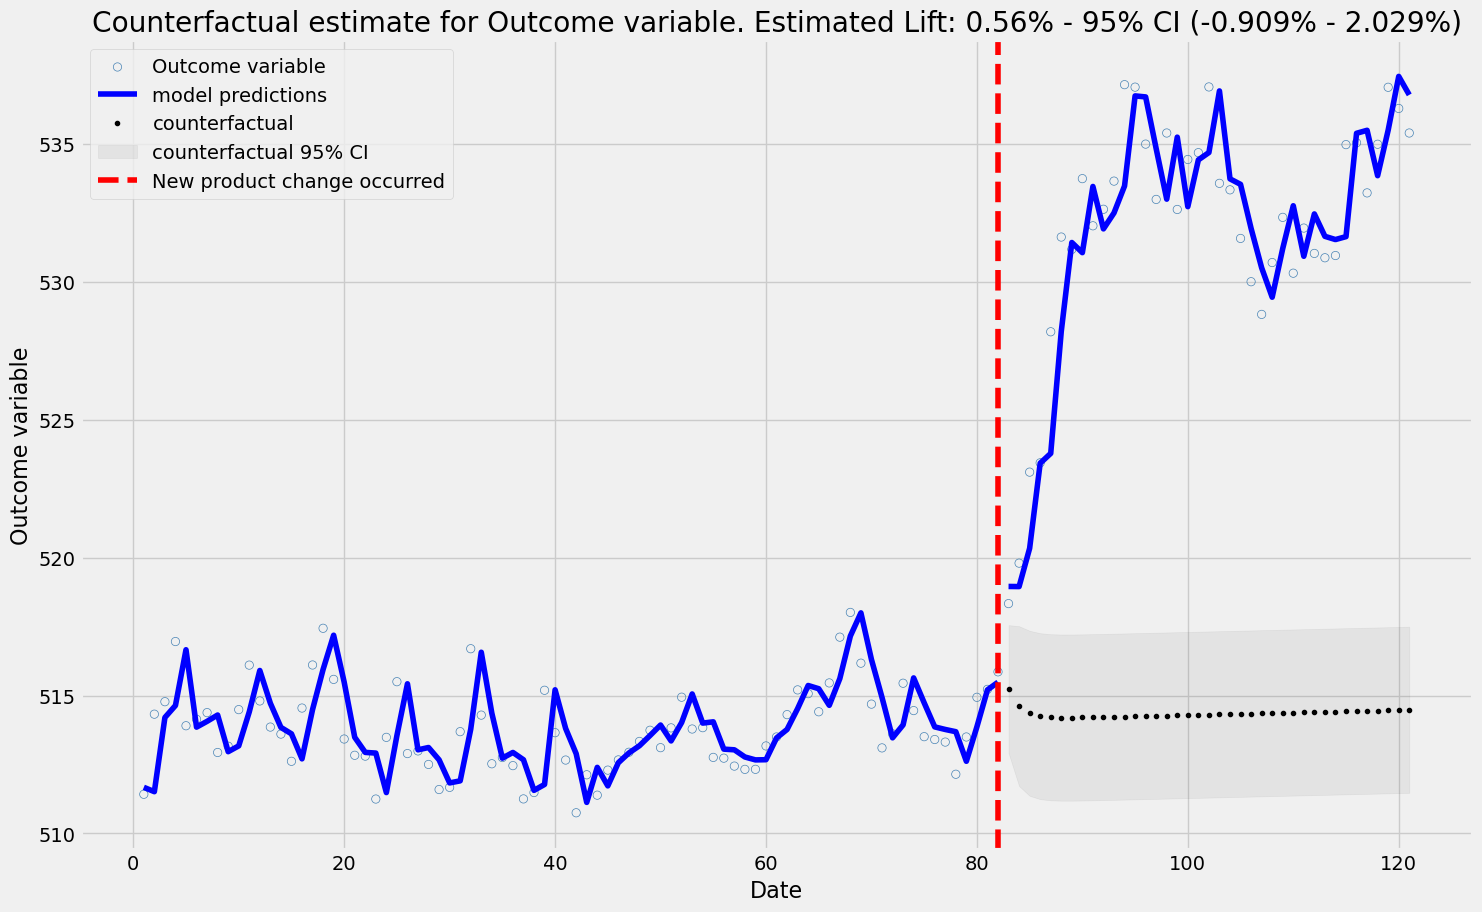

In [91]:
auto_arima_interrupted_ts.interrupted_time_series(df=df, 
                                                  model_type='auto_arima_interrupted_time_series', 
                                                  date_col='date', 
                                                  outcome_name='Outcome variable', 
                                                  outcome_col='outcome', 
                                                  treatment_name='New product change')